In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Input, LSTM
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from encoding_4 import generate_dataset_scheme_4, sequence_length, create_midi_from_results
from keras.callbacks import ModelCheckpoint
from music21 import converter , instrument, note, chord 
import pickle
import matplotlib.pyplot as plt


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [2]:
model = load_model('stacked_256.h5')

In [15]:
n_a = 256
#reshapor = Reshape((1, n_values))


def initialize_rnn(X, n_a, n_values):
  	model = Sequential()
  	model.add(LSTM(n_a, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
  	model.add(LSTM(n_a, return_sequences = True))
  	model.add(Flatten())
  	model.add(Dense(n_values))
  	model.add(Activation('softmax'))
  	model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop',  metrics=['accuracy'])
  	return model


def train_rnn(trainFlag):
	X, Y, pitchnames = generate_dataset_scheme_4('dev', 21)
	print(X.shape, Y.shape)
	n_values = Y.shape[1]
	model = initialize_rnn(X, n_a, n_values)
	#model.load_weights('weights-improvement-191-0.0000-bigger.hdf5')
	filepath = "weights_aws-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
	if trainFlag:
		checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 0, save_best_only = True, mode = 'min')
		history = model.fit(X, Y, validation_split =.05, epochs = 10, batch_size = 200, callbacks = [checkpoint])
		model.save('stacked_256.h5')
		#with open('/trainHistoryDict', 'wb') as file_pi:
			#pickle.dump(history.history, file_pi)
	return model, X, pitchnames, n_values, history

def generate_music(model, X, pitchnames, n_values):
	model.load_weights('weights_aws-improvement-123-0.0117-bigger.hdf5')
	start_ind = np.random.randint(0, len(X) -1)
	int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
	pattern = X[start_ind]
	print("start index ", start_ind)
	print(pattern.shape)
	pred_out = []

	#generate 100 notes. 
	for n_ind in range(300): 
		pred_in = np.reshape(pattern, (1, len(pattern), 1))
		pred_in = pred_in/float(n_values)

		pred = model.predict(pred_in, verbose= 0)
		ind = np.argmax(pred)
		result = int_to_note[ind]
		pred_out.append(result)

		pattern = np.append(pattern, ind)
		pattern = pattern[1:len(pattern)]

	return pred_out


 
def main():
	model, X, pitchnames, n_values, history = train_rnn(True)
	for ii in range(10): 
		results = generate_music(model, X, pitchnames, n_values)
		print ("creating midi file no. ", ii)
		create_midi_from_results(results, 'fuego_flames{}.mid'.format(ii))
		print ('midi created')

In [ ]:
model, X, pitchnames, n_values, history = train_rnn(True)

generating midi from  brahms_opus1_1_format0.mid
generating midi from  haydn_7_1_format0.mid
generating midi from  mz_331_2_format0.mid
generating midi from  beethoven_opus10_2_format0.mid
generating midi from  clementi_opus36_5_3_format0.mid
generating midi from  mendel_op30_5_format0.mid
generating midi from  alb_se3_format0.mid
generating midi from  grieg_album_format0.mid
generating midi from  beethoven_les_adieux_1_format0.mid
generating midi from  chpn_op25_e3_format0.mid
generating midi from  ty_oktober_format0.mid
generating midi from  scn16_3_format0.mid
generating midi from  alb_esp4_format0.mid
generating midi from  haydn_33_1_format0.mid
generating midi from  chpn-p1_format0.mid
generating midi from  debussy_cc_6_format0.mid
generating midi from  schumm-4_format0.mid
generating midi from  schu_143_2_format0.mid
(23505, 100, 1) (23505, 302)
Train on 22329 samples, validate on 1176 samples
Epoch 1/10
22329/22329 [==============================] - 39s 2ms/step - loss: 4.7984 -

In [12]:
print (history.history)

{'val_loss': [4.977128525169528, 4.89703875820653], 'val_acc': [0.005102041058660466, 0.036564625951708576], 'loss': [5.012622025368638, 4.7375430053899885], 'acc': [0.029154910860599285, 0.03179721465649033]}


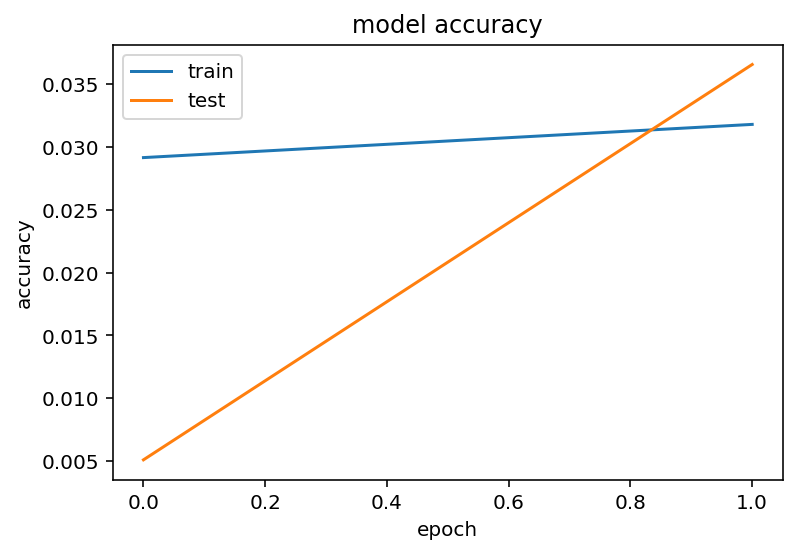

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

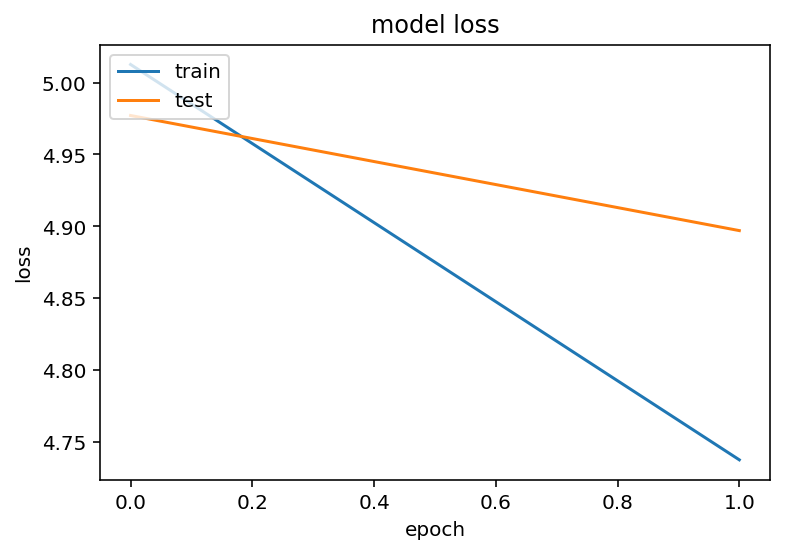

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()